# Charting PH History from Past SONA Content
This is the notebook for the post on my blog of the same title as above. This notebook:
* sums up the word count of all SONAs delivered by each Philippine President since Manuel Quezon,
* uses data on content/topic percentages to determine the components of the entire body of his/her SONA speeches,
* charts the above results.

## Data Sources and Scrapers
The dataset has been put together by scraping [this site](http://www.gov.ph/past-sona-speeches/) and [this site](http://malacanang.gov.ph/sona-content-charts-and-word-clouds/) using [this spider](https://github.com/larpquire/ph_sona_scrape) and [this scraper](https://github.com/larpquire/ph_sona_topics_scraper), respectively.

## The Imports
First, we start with the imports

In [1]:
import json
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz, process
from textblob import TextBlob

The last two imports probably need a little more explanation. The package `fuzzywuzzy` is used to match different strings with very subtle differences such as capitalizations and missing/added characters (you often see these with names). Next, the package `textblob` is a high-level wrapping for the heavy-duty `nltk` library, so it's going to be used for basic text processing here.

## Reading the Raw Data
The raw data are stored in two files `sona_raw_data.json` and `sona_topics_data.json` located in the `Data` directory. So, it would probably be wise to create a couple of lists to hold the read data:

In [2]:
sona_raw = []
sona_topics = []

### The Text Data

In [3]:
with open('Data\\sona_raw_data.json') as f:
    sona_raw = json.load(f)

Let's see what we have:'

In [4]:
len(sona_raw)

77

... which makes sense since there are (as of this date) 77 SONAs delivered by 13 presidents in all. What else?

In [5]:
sona_raw[0].keys()

[u'delivered', u'title', u'text', u'author']

From the above, we see that each entry in the `sona_raw` list is a dictionary with keys `delivered` (date speech was delivered/released), `text` (the body of the speech) and other fields which are fairly self-explanatory. We could have directly turned the `sona_raw_data.json` file into a pandas DF, but we wanted to first make sure that it was what we think it was.

### The Topics Data
Similarly, we have:

In [6]:
with open('Data\\sona_topics_data.json') as g:
    sona_topics = json.load(g)

In [7]:
len(sona_topics)

77

In [8]:
sona_topics[0].keys()

[u'delivered', u'topics', u'author', u'title']

In [9]:
sona_topics[0]['topics']

{u'Independence': u'46%',
 u'International Relations': u'15%',
 u'Loyalty to the United States': u'8%',
 u'National Security/Military': u'15%',
 u'Nationalism': u'12%',
 u'War reparations/veterans': u'4%'}

Each `sona_topics` element is a dictionary with the above keys. The `topics` element is a dictionary with content as keys and percentage of speech as values.

## Preliminary Data Cleanup and Preparation
It looks like we can now turn `sona_raw` into a pandas dataframe, so we'll do it here:

In [10]:
df_raw = pd.DataFrame(sona_raw)

In [11]:
df_raw.head()

,author,delivered,text,title
0,Manuel L. Quezon,1937-10-18 11:53:02+00:00,[Delivered at the Opening of the Second Sessio...,"Improvement of Philippine Conditions, Philippi..."
1,Manuel L. Quezon,1936-06-16 01:12:41+00:00,\r\n\r\n\r\n\r\n[Delivered at the Opening of t...,On the Country’s Conditions and Problems
2,Ramon Magsaysay,1956-01-23 12:53:09+00:00,"\r\n[Released on January 23, 1956]\r\nMR. PRES...",Address on the State of the Nation
3,Ramon Magsaysay,1955-01-24 11:36:53+00:00,"\r\n[Released on January 24, 1955]\r\nMr. Pres...",Address on the State of the Nation
4,Ramon Magsaysay,1957-01-28 12:58:25+00:00,"\r\n[Released on January 28, 1957]\r\nMR. PRES...",Address on the State of the Nation


In [12]:
df_raw.tail()

,author,delivered,text,title
72,Manuel L. Quezon,1941-01-31 12:26:57+00:00,[Delivered at the Opening of the Third Session...,The State of the Nation
73,Sergio Osmeña,1945-06-09 11:58:21+00:00,"[Delivered on June 9, 1945]\r\nGENTLEMEN OF TH...",Message to the First Congress of the Commonwea...
74,Manuel L. Quezon,1940-01-22 12:21:32+00:00,[Delivered at the Opening of the Second Sessio...,The State of the Nation
75,President Roxas on First State of the Nation A...,1946-06-03 13:08:57+00:00,"\r\n\r\n\r\n\r\n[Released on June 3, 1946]\r\n...",The State of the Nation
76,Manuel Roxas,1947-01-27 12:07:40+00:00,\r\n\r\n[Delivered at the Opening of the Secon...,Message on the State of the Nation


### Cleaning up the SONA Text
Since one of our goals here is to find the total word count, we may need to clean up the contents of the `text` column a bit, since these seem to include strings such as "[Some text here...]" which aren't part of the speech proper. In particular, the actual text of the speech begins after "[Delivered at the <venue> on <month> <day>, <year>]" Thus, we apply the below operation on the `text` field.

In [13]:
def cleanup_text(text):
    pattern = r' \d{4}\]'
    mo = re.search(pattern, text)
    if mo:
        return text[mo.start() + len(pattern): ].strip()
    return text.strip()

In [14]:
df_raw['text'] = df_raw['text'].apply(lambda x: cleanup_text(x))

Also, since we probably won't be needing the time and tz components of the `delivered` field entries (traditionally, no two SONAs are delivered on the same day, making this column a good candidate for a unique key on which to merge our DFs if needed), we'll also clean the `delivered` column as follows:

In [15]:
df_raw['delivered'] = df_raw['delivered'].apply(lambda x: x.split(' ')[0])

In [16]:
df_raw.head()

,author,delivered,text,title
0,Manuel L. Quezon,1937-10-18,"Mr. Speaker, Gentlemen of the National Assembl...","Improvement of Philippine Conditions, Philippi..."
1,Manuel L. Quezon,1936-06-16,"Mr. Speaker, Gentlemen of the National Assembl...",On the Country’s Conditions and Problems
2,Ramon Magsaysay,1956-01-23,"MR. PRESIDENT, MR. SPEAKER, MEMBERS OF CONGRES...",Address on the State of the Nation
3,Ramon Magsaysay,1955-01-24,"Mr. President, Mr. Speaker, Members of Congres...",Address on the State of the Nation
4,Ramon Magsaysay,1957-01-28,"MR. PRESIDENT, MR. SPEAKER, MEMBERS OF CONGRES...",Address on the State of the Nation


### Word Counts
We run the below operation to include the word count of each SONA speech into the `df_raw` dataframe.

In [17]:
df_raw['words'] = df_raw['text'].apply(lambda x: len(TextBlob(x).words))

In [18]:
df_raw.head()

,author,delivered,text,title,words
0,Manuel L. Quezon,1937-10-18,"Mr. Speaker, Gentlemen of the National Assembl...","Improvement of Philippine Conditions, Philippi...",5620
1,Manuel L. Quezon,1936-06-16,"Mr. Speaker, Gentlemen of the National Assembl...",On the Country’s Conditions and Problems,7099
2,Ramon Magsaysay,1956-01-23,"MR. PRESIDENT, MR. SPEAKER, MEMBERS OF CONGRES...",Address on the State of the Nation,4458
3,Ramon Magsaysay,1955-01-24,"Mr. President, Mr. Speaker, Members of Congres...",Address on the State of the Nation,6466
4,Ramon Magsaysay,1957-01-28,"MR. PRESIDENT, MR. SPEAKER, MEMBERS OF CONGRES...",Address on the State of the Nation,6533


In [19]:
df_raw.sort_values(by='words', ascending=False)[
    ['author', 'delivered', 'title', 'words']
]

,author,delivered,title,words
66,Ferdinand E. Marcos,1969-01-27,New Filipinism: The Turning Point,27139
58,Ferdinand E. Marcos,1972-01-24,"Strength through Crisis, Growth in Freedom",22782
64,Ferdinand E. Marcos,1970-01-26,National Discipline: The Key to Our Future,18960
62,Ferdinand E. Marcos,1968-01-22,A Nation of Achievers,15629
60,Ferdinand E. Marcos,1967-01-23,The Epic of Nation-Building,14456
57,Ferdinand E. Marcos,1971-01-25,The Democratic Revolution,14031
70,Diosdado Macapagal,1963-01-28,The State of the Nation 1963,13301
65,Diosdado Macapagal,1965-01-25,The Philippines after Three Years (1962–1965),12974
23,Benigno S. Aquino III,2013-07-22,Fourth State of the Nation Address,12757
76,Manuel Roxas,1947-01-27,Message on the State of the Nation,12664


Don't mind the numbers under the first column of the table above. They're just the original indices from the `df_raw` dataframe.

### Preparing the SONA Topics Data
Before we turn the data in the `sona_topics` list into a pandas dataframe, we have to do some initial processing on it to avoid unexpected results later on. First, since each entry in the list contains a dictionary of the content type-percentage data, we apply the following so that the resulting data structure will be spread out into separate rows and thus avoid `NaN` or null entries when we change it into a DF later.

In [20]:
topics_data = []

In [21]:
for sona in sona_topics:
    for topic, pct in sona['topics'].iteritems():
        data = {k: v for k, v in sona.iteritems() if k != 'topics'}
        data['topic'] = topic
        data['percent'] = float(pct[:-1])                    # convert unicode to float
        topics_data.append(data)

Now, we're ready to make this into a dataframe.

In [22]:
df_topics = pd.DataFrame(
    topics_data, columns=[
        'author', 'title', 'delivered', 'topic', 'percent'
    ]
)

In [23]:
df_topics.columns

Index([u'author', u'title', u'delivered', u'topic', u'percent'], dtype='object')

In [24]:
df_topics.head()

,author,title,delivered,topic,percent
0,Sergio Osmeña,Message to the First Congress of the Commonwea...,"June 9, 1945",International Relations,15.0
1,Sergio Osmeña,Message to the First Congress of the Commonwea...,"June 9, 1945",Loyalty to the United States,8.0
2,Sergio Osmeña,Message to the First Congress of the Commonwea...,"June 9, 1945",Nationalism,12.0
3,Sergio Osmeña,Message to the First Congress of the Commonwea...,"June 9, 1945",War reparations/veterans,4.0
4,Sergio Osmeña,Message to the First Congress of the Commonwea...,"June 9, 1945",National Security/Military,15.0


In [25]:
df_topics.tail()

,author,title,delivered,topic,percent
749,Manuel L. Quezon,Seventh State of the Nation Address of Preside...,"January 31, 1941",Health,4.0
750,Manuel L. Quezon,Seventh State of the Nation Address of Preside...,"January 31, 1941",Agriculture/Food Security,6.0
751,Manuel L. Quezon,Seventh State of the Nation Address of Preside...,"January 31, 1941",Others,31.0
752,Manuel L. Quezon,Seventh State of the Nation Address of Preside...,"January 31, 1941",Education,4.0
753,Manuel L. Quezon,Seventh State of the Nation Address of Preside...,"January 31, 1941",Economy,14.0


We can see that the `df_topics.delivered` column needs to be converted into a YYYY-mm-dd format so that it's going to have the same format as the `delivered` column field of the `df_raw` DF. So we apply:

In [26]:
format_date = lambda x: datetime.strptime(x, '%B %d, %Y').strftime('%Y-%m-%d')

In [27]:
df_topics['delivered'] = df_topics['delivered'].apply(format_date)

In [28]:
df_topics.head()

,author,title,delivered,topic,percent
0,Sergio Osmeña,Message to the First Congress of the Commonwea...,1945-06-09,International Relations,15.0
1,Sergio Osmeña,Message to the First Congress of the Commonwea...,1945-06-09,Loyalty to the United States,8.0
2,Sergio Osmeña,Message to the First Congress of the Commonwea...,1945-06-09,Nationalism,12.0
3,Sergio Osmeña,Message to the First Congress of the Commonwea...,1945-06-09,War reparations/veterans,4.0
4,Sergio Osmeña,Message to the First Congress of the Commonwea...,1945-06-09,National Security/Military,15.0


Let's check if we can really use `delivered` as a valid key for merging or matching our two dataframes. These two columns should be composed of exactly the same set of elements.

In [29]:
set(df_raw.delivered) == set(df_topics.delivered)

False

In [30]:
common_dates = set(df_raw.delivered).intersection(set(df_topics.delivered))

In [31]:
common_dates

{'1935-11-25',
 '1936-06-16',
 '1937-10-18',
 '1938-01-24',
 '1939-01-24',
 '1940-01-22',
 '1941-01-31',
 '1945-06-09',
 '1946-06-03',
 '1947-01-27',
 '1948-01-26',
 '1949-01-24',
 '1950-01-23',
 '1951-01-22',
 '1952-01-28',
 '1953-01-26',
 '1954-01-25',
 '1955-01-24',
 '1956-01-23',
 '1957-01-28',
 '1958-01-27',
 '1959-01-26',
 '1960-01-25',
 '1961-01-23',
 '1962-01-22',
 '1963-01-28',
 '1964-01-27',
 '1965-01-25',
 '1966-01-24',
 '1967-01-23',
 '1968-01-22',
 '1969-01-27',
 '1970-01-26',
 '1971-01-25',
 '1972-01-24',
 '1973-09-21',
 '1974-09-21',
 '1975-09-19',
 '1976-09-21',
 '1977-09-21',
 '1978-06-12',
 '1979-07-23',
 '1980-07-28',
 '1981-07-27',
 '1982-07-26',
 '1983-01-17',
 '1984-07-23',
 '1985-07-22',
 '1987-07-27',
 '1988-07-25',
 '1989-07-24',
 '1990-07-23',
 '1991-07-22',
 '1992-07-27',
 '1993-07-26',
 '1994-07-25',
 '1995-07-24',
 '1996-07-22',
 '1997-07-28',
 '1998-07-27',
 '1999-07-26',
 '2000-07-24',
 '2001-07-23',
 '2002-07-22',
 '2003-07-28',
 '2004-07-26',
 '2005-07-

In [32]:
len(common_dates)

76

In [33]:
set(df_raw.delivered).difference(set(df_topics.delivered))

{u'2015-07-27'}

So there's just one particular date that's found in `df_raw.delivered` but not in `df_topics.delivered`, and if I'm not mistaken, this refers to former Pres. PNoy's last SONA.

In [34]:
df_topics[~df_topics.delivered.isin(common_dates)]

,author,title,delivered,topic,percent
664,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Criminality/Rule of Law/Justice,2.0
665,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Infrastructure,5.0
666,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Social welfare,5.0
667,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,International relations,2.0
668,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Business,2.0
669,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Industry,2.0
670,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Others,9.0
671,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Transportation & Communications,3.0
672,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Government Service,5.0
673,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-28,Governance/Reform,17.0


Clearly, entries in the `df_topics.delivered` column pertaining to PNoy's last SONA are incorrect. July 28, 2015 was a Tuesday, and SONAs are customarily delivered on the [fourth Monday of July](http://www.gov.ph/the-state-of-the-nation-address-traditions-and-history/) as prescribed by the 1987 Constitution. (I did my homework). So let us correct this historic error:

In [35]:
df_topics.loc[~df_topics.delivered.isin(common_dates), 'delivered'] = '2015-07-27'

In [36]:
set(df_raw.delivered) == set(df_topics.delivered)

True

In [37]:
df_topics.loc[664:684, ]

,author,title,delivered,topic,percent
664,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Criminality/Rule of Law/Justice,2.0
665,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Infrastructure,5.0
666,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Social welfare,5.0
667,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,International relations,2.0
668,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Business,2.0
669,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Industry,2.0
670,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Others,9.0
671,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Transportation & Communications,3.0
672,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Government Service,5.0
673,Benigno S. Aquino III,Sixth State of the Nation Address of President...,2015-07-27,Governance/Reform,17.0


That's much better. A couple more things to check before we proceed:

### Checking Correct Number of Unique Names
Let's see to it that we have exactly 13 distinct names of Presidents under the `df_topics.author` column since we'll also need to group by President later on.

In [38]:
names = pd.unique(df_topics.author.ravel())

In [39]:
len(names)

13

In [40]:
names

array([u'Sergio Osme\xf1a', u'Manuel Roxas', u'Elpidio Quirino',
       u'Ramon Magsaysay', u'Carlos P. Garcia', u'Diosdado Macapagal',
       u'Ferdinand E. Marcos', u'Corazon C. Aquino', u'Fidel V. Ramos',
       u'Joseph Ejercito Estrada', u'Gloria Macapagal-Arroyo',
       u'Benigno S. Aquino III', u'Manuel L. Quezon'], dtype=object)

Everything seems fine in terms of the Presidents' names under the `df_topics` entries.

Just to be sure that we'll be able to match by names later, let's make the names in the `author` of `df_raw` exactly the same as  their counterparts in `df_topics`. Here, we use the handy `fuzzywuzzy` package to help us do this much faster and more accurately.

In [41]:
def fix_names(orig_name):
    choice, _ = process.extractOne(orig_name, names)
    return choice

In [42]:
df_raw['author'] = df_raw['author'].apply(lambda x: fix_names(x))

Let's check:

In [43]:
pd.unique(df_raw.author.ravel())

array([u'Manuel L. Quezon', u'Ramon Magsaysay', u'Elpidio Quirino',
       u'Manuel Roxas', u'Carlos P. Garcia', u'Benigno S. Aquino III',
       u'Gloria Macapagal-Arroyo', u'Joseph Ejercito Estrada',
       u'Fidel V. Ramos', u'Corazon C. Aquino', u'Ferdinand E. Marcos',
       u'Diosdado Macapagal', u'Sergio Osme\xf1a'], dtype=object)

In [44]:
set(df_raw.author) == set(df_topics.author)

True

### Combining Topic Categories with Very Similar Keywords
In order to avoid slight differences in topic category strings (such as differences in capitalization, extra spaces, plural/singular, etc.) leading to redundant entries, we again use the fuzzywuzzy module to make sure that very similar topic strings are combined under a single grouping.

In [45]:
all_topics = pd.unique(df_topics.topic.ravel())

In [46]:
print all_topics

[u'International Relations' u'Loyalty to the United States' u'Nationalism'
 u'War reparations/veterans' u'National Security/Military' u'Independence'
 u'Infrastructure' u'Budget & Finance' u'Transportation & Communications'
 u'Peace/Insurgency/Terrorism' u'Agriculture/Food Security' u'Others'
 u'Health' u'Labor/Employment/Wages' u'Economy'
 u'Criminality/Rule of Law/Justice' u'Governance/Reform'
 u'Bills, Policies, & Legislation' u'Social Welfare' u'Trade' u'Industry'
 u'Tax/Revenue' u'Inflation' u'Education'
 u'Agrarian-Land/Reform/Distribution/Settlement' u'Government Service'
 u'Anti-Corruption/Anomalies' u'Development/Progress' u'Other'
 u'Population/Stats' u'Basic/Public Services' u'Elections/Electoral System'
 u'Human Rights/Marginalized/Social Justice' u'Executive Issuances' u'Debt'
 u'Democracy' u'Constitutional Change/Amendments' u'Energy & Oil'
 u'Appointments' u'Poverty/Alleviation' u'Environment'
 u'Calamity & Disaster / Preparedness' u'Elections / Electoral System'
 u'Tour

Here, we can see at least a couple of potential candidates to be combined (e.g., "Others" and "Other" as well as entries with slight differences in the number of spaces). To group these terms under a single topic category, we use the following approach which I adopted from a very helpful [Stack Overflow answer](http://stackoverflow.com/questions/35171710/how-to-group-words-whose-levenshtein-distance-is-more-than-80-percent-in-python):

In [47]:
keywords = {}
for topic in all_topics:
    for kw in keywords:
        if fuzz.ratio(topic, kw) > 90:
            keywords[kw].append(topic)
    else:                                 # not wrong indentation level
        keywords[topic] = []              # creates empty list

In [48]:
for replacement, originals in keywords.iteritems():
    if originals:
        for orig in originals:
            df_topics.loc[df_topics.topic == orig, 'topic'] = replacement

Let's see if we have what we want:

In [49]:
all_topics_combined = pd.unique(df_topics.topic.ravel())

In [50]:
all_topics_combined

array([u'International Relations', u'Loyalty to the United States',
       u'Nationalism', u'War reparations/veterans',
       u'National Security/Military', u'Independence', u'Infrastructure',
       u'Budget & Finance', u'Transportation & Communications',
       u'Peace/Insurgency/Terrorism', u'Agriculture/Food Security',
       u'Others', u'Health', u'Labor/Employment/Wages', u'Economy',
       u'Criminality/Rule of Law/Justice', u'Governance/Reform',
       u'Bills, Policies, & Legislation', u'Social Welfare', u'Trade',
       u'Industry', u'Tax/Revenue', u'Inflation', u'Education',
       u'Agrarian-Land/Reform/Distribution/Settlement',
       u'Government Service', u'Anti-Corruption/Anomalies',
       u'Development/Progress', u'Population/Stats',
       u'Basic/Public Services', u'Elections/Electoral System',
       u'Human Rights/Marginalized/Social Justice', u'Executive Issuances',
       u'Debt', u'Democracy', u'Constitutional Change/Amendments',
       u'Energy & Oil', u'Appo

In [51]:
len(all_topics_combined)

49

It now seems okay to proceed.

### Checking Percentage Totals
Now we also check whether the topic percentages for each SONA really add up to 100%.

In [52]:
df_grouped_sona = df_topics.groupby(by='delivered', as_index=False)

In [53]:
df_topics_pc_totals_by_sona = df_grouped_sona.aggregate(np.sum)

In [54]:
df_topics_pc_totals_by_sona[df_topics_pc_totals_by_sona.percent != 100]

,delivered,percent
0,1935-11-25,101.0
36,1974-09-21,99.0
58,1997-07-28,99.0
70,2009-07-27,98.0
71,2010-07-26,96.0
76,2015-07-27,95.0


We see some totals not adding up to exactly 100, but some of these are probably just due to rounding. But there are entries above (such as the 2015-07-27 total of 95) which is unlikely to have resulted from rounding errors alone. I've revisited the [SONA Content & Word Cloud page](http://malacanang.gov.ph/sona-content-charts-and-word-clouds/) and found that the figures for the 2015-07-27 SONA do show that the topic percentages add up to exactly 95. I didn't check the other SONAs with troublesome topic percentage totals, but I suspect the discrepancies can similarly be traced to erroneous values shown on the SONA webpage itself.

A possible solution is to offset the shortfall/excess against that SONA's "Others" topic category. To do that we first need to make sure that such a category does exist for each of the SONAs in the `df_topics_pc_totals_by_sona` DF.

In [55]:
tricky_sonas = df_topics_pc_totals_by_sona.loc[
    df_topics_pc_totals_by_sona.percent != 100,
    'delivered'
].ravel()

In [56]:
for sona, items in df_grouped_sona:
    if sona in tricky_sonas:
        if 'Others' not in items.topic.ravel():
            print items[['delivered', 'topic']]

      delivered                       topic
685  1935-11-25                 Nationalism
686  1935-11-25           Governance/Reform
687  1935-11-25                Appointments
688  1935-11-25  Peace/Insurgency/Terrorism
689  1935-11-25            Budget & Finance
690  1935-11-25                   Education
691  1935-11-25  National Security/Military
692  1935-11-25                Independence
693  1935-11-25                     Economy


It turns out there's exactly one "tricky" SONA which also doesn't have an "Others" (or similar) category we can use to offset the deficit/excess with. And if we look at the table above that shows the percent totals, we see that it's actually the SONA with the 101% topic percentage total.

So instead of writing a straightforward workaround (simply addings/subtracting the shortage/excess to/from the "Others" topic category), we'll also have to take this case into account. What I have in mind (though, you might disagree with me on this) is to evenly distribute the discrepancy among the SONA's existing topic categories if the "Others" topic category isn't present. I think this would work because it wouldn't affect the sizes of the topics relative to each other (since each of these topic categories would be changed by the same amount). So, let's put this into code:

In [57]:
for sona in tricky_sonas:
    cond1 = df_topics.delivered == sona
    cond2 = False
    
    topics = df_topics.loc[cond1, 'topic'].ravel()
    offset = 100 - float(
        df_topics_pc_totals_by_sona.loc[
            df_topics_pc_totals_by_sona.delivered == sona, 'percent'
        ]
    )
    
    if 'Others' in topics:
        cond2 = df_topics.topic == 'Others'
    else:
        cond2 = df_topics.topic.isin(topics)
        offset = offset / len(topics)
    
    df_topics.loc[cond1 & cond2, 'percent'] += offset

Let's check:

In [58]:
df_grouped_sona = df_topics.groupby(by='delivered', as_index=False)
df_topics_pc_totals_by_sona = df_grouped_sona.aggregate(np.sum)
df_topics_pc_totals_by_sona[df_topics_pc_totals_by_sona.percent != 100]

,delivered,percent
0,1935-11-25,100.0


The previous command should have returned a null result, but the above is probably as close as we'll get to 100%. It's probably just due to rounding, though. And so it looks like we're all set.

## Computing the Word Counts per Topic
Now we get an estimate of how many words in a particular SONA have been devoted to talking about a specific topic. To do that, we write another helper function that multiplies the topic percentages with the corresponding SONA word count. We then assign the results to another column in `df_topics`.

In [59]:
def get_topic_wc(row):
    topic_pc = row['percent'] / 100
    total_wc = int(df_raw.loc[df_raw.delivered == row['delivered'], 'words'])
    return topic_pc * total_wc

In [60]:
df_topics['topic_wc'] = df_topics.apply(lambda x: get_topic_wc(x), axis=1)

Let's see if this checks out by looking at a particular SONA.

In [61]:
test_sona = '2015-07-27'

In [62]:
df_raw[df_raw.delivered == test_sona]['words']

20    12202
Name: words, dtype: int64

In [63]:
df_topics[df_topics.delivered == test_sona]['topic_wc'].sum()

12202.000000000002

That's good enough.

## Getting the (Aggregated) Topics Percentages
In this part, we'll be aggregating by President and then by SONA topic to achieve our goal of finding out how much a particular content/topic figures in the entirety of a President's SONA speeches. But first, let's find how many distinct SONA topics there are for all 13 Presidents:

In [64]:
all_topics = pd.unique(df_topics.topic.ravel())

In [65]:
all_topics

array([u'International Relations', u'Loyalty to the United States',
       u'Nationalism', u'War reparations/veterans',
       u'National Security/Military', u'Independence', u'Infrastructure',
       u'Budget & Finance', u'Transportation & Communications',
       u'Peace/Insurgency/Terrorism', u'Agriculture/Food Security',
       u'Others', u'Health', u'Labor/Employment/Wages', u'Economy',
       u'Criminality/Rule of Law/Justice', u'Governance/Reform',
       u'Bills, Policies, & Legislation', u'Social Welfare', u'Trade',
       u'Industry', u'Tax/Revenue', u'Inflation', u'Education',
       u'Agrarian-Land/Reform/Distribution/Settlement',
       u'Government Service', u'Anti-Corruption/Anomalies',
       u'Development/Progress', u'Population/Stats',
       u'Basic/Public Services', u'Elections/Electoral System',
       u'Human Rights/Marginalized/Social Justice', u'Executive Issuances',
       u'Debt', u'Democracy', u'Constitutional Change/Amendments',
       u'Energy & Oil', u'Appo

In [66]:
len(all_topics)

49

That's a lot of categories to consider in a single figure, so this probably supports our president-by-president approach for analyzing and visualizing. So now, let's group the `df_topics` dataframe by `author` and `topic` and then aggregate the results in a new dataframe.

In [67]:
df_by_author_topic = df_topics.groupby(
    by=['author', 'topic'],
    as_index=False
).agg(np.sum)[['author', 'topic', 'topic_wc']]

In [68]:
df_by_author_topic.head(20)

,author,topic,topic_wc
0,Benigno S. Aquino III,Agriculture/Food Security,510.28
1,Benigno S. Aquino III,Anti-Corruption/Anomalies,4774.40
2,Benigno S. Aquino III,Appointments,366.06
3,Benigno S. Aquino III,Budget & Finance,1376.99
4,Benigno S. Aquino III,Business,244.04
5,Benigno S. Aquino III,Calamity & Disaster / Preparedness,2068.41
6,Benigno S. Aquino III,Criminality/Rule of Law/Justice,3264.55
7,Benigno S. Aquino III,Development/Progress,1752.68
8,Benigno S. Aquino III,Economy,1851.36
9,Benigno S. Aquino III,Education,1420.43


It makes no sense to include the sum of the individual topic percentages, so we excluded it in the columns of the resulting `df_by_author_topic`.

Now, we can get the percentage of each of the topic categories to a President's entire body of SONAs by dividing the corresponding `df_by_author_topic.topic_wc` entries to the sum of `df_raw.words` values associated with that particular President:

In [69]:
df_total_wc = df_raw.groupby('author').agg(np.sum)

In [70]:
def get_main_pct(row):
    total_wc = int(df_total_wc.loc[row['author'], 'words'])
    return (row['topic_wc'] / total_wc) * 100

In [71]:
df_by_author_topic['topic_main_pct'] = df_by_author_topic.apply(
    lambda x: get_main_pct(x), axis=1
)

In [72]:
# Saving it for later
df_by_author_topic.to_csv('Output\\Tables\\main_results.csv', encoding='utf-8')

## Plotting the Good Stuff

Tiem to do what we've set out to do.

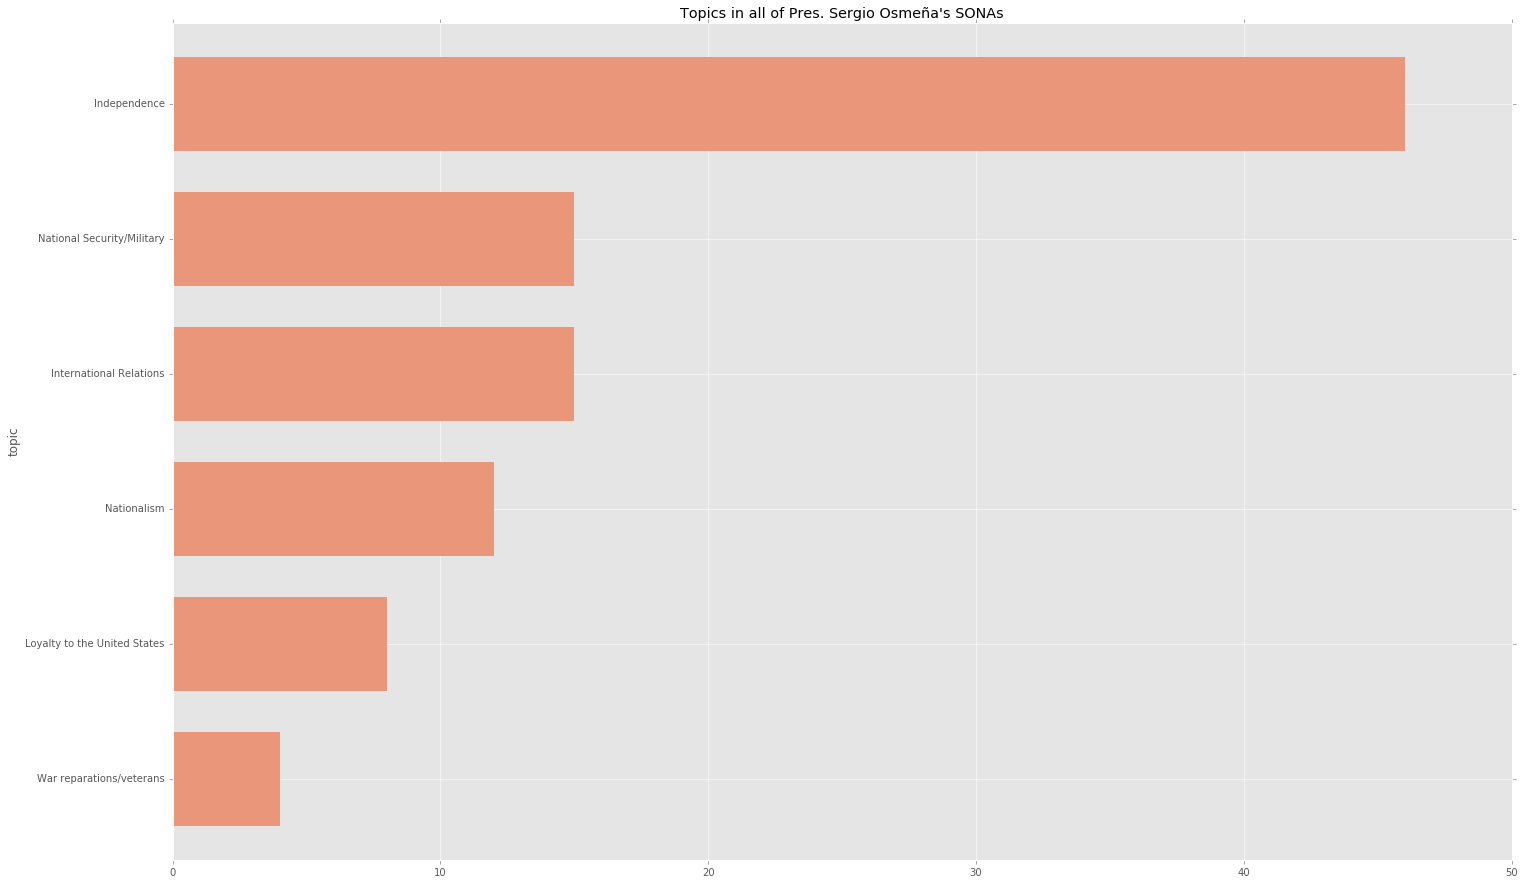

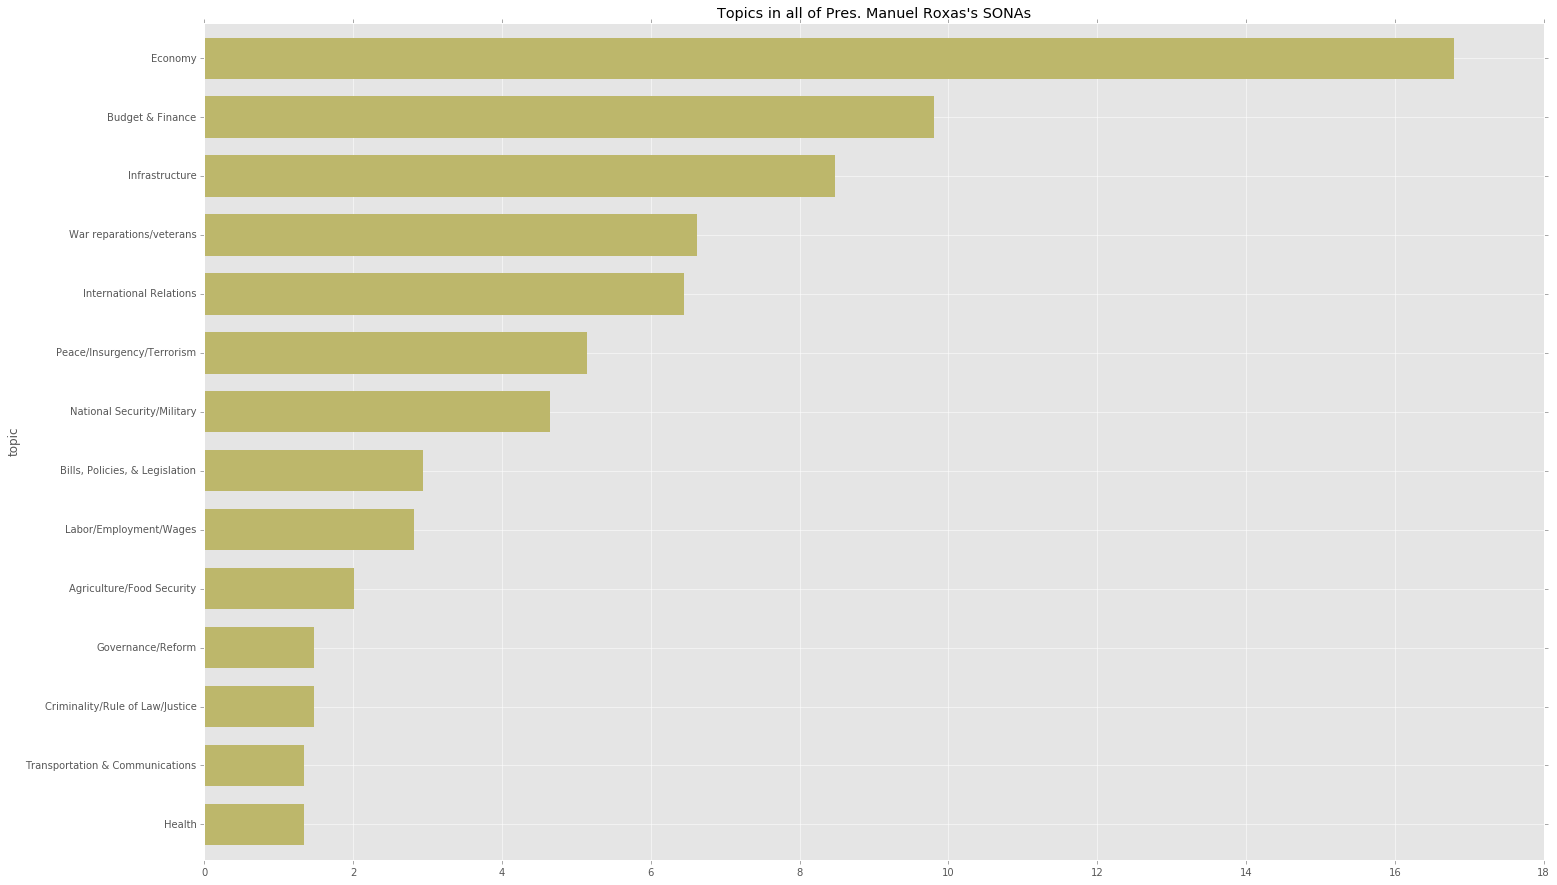

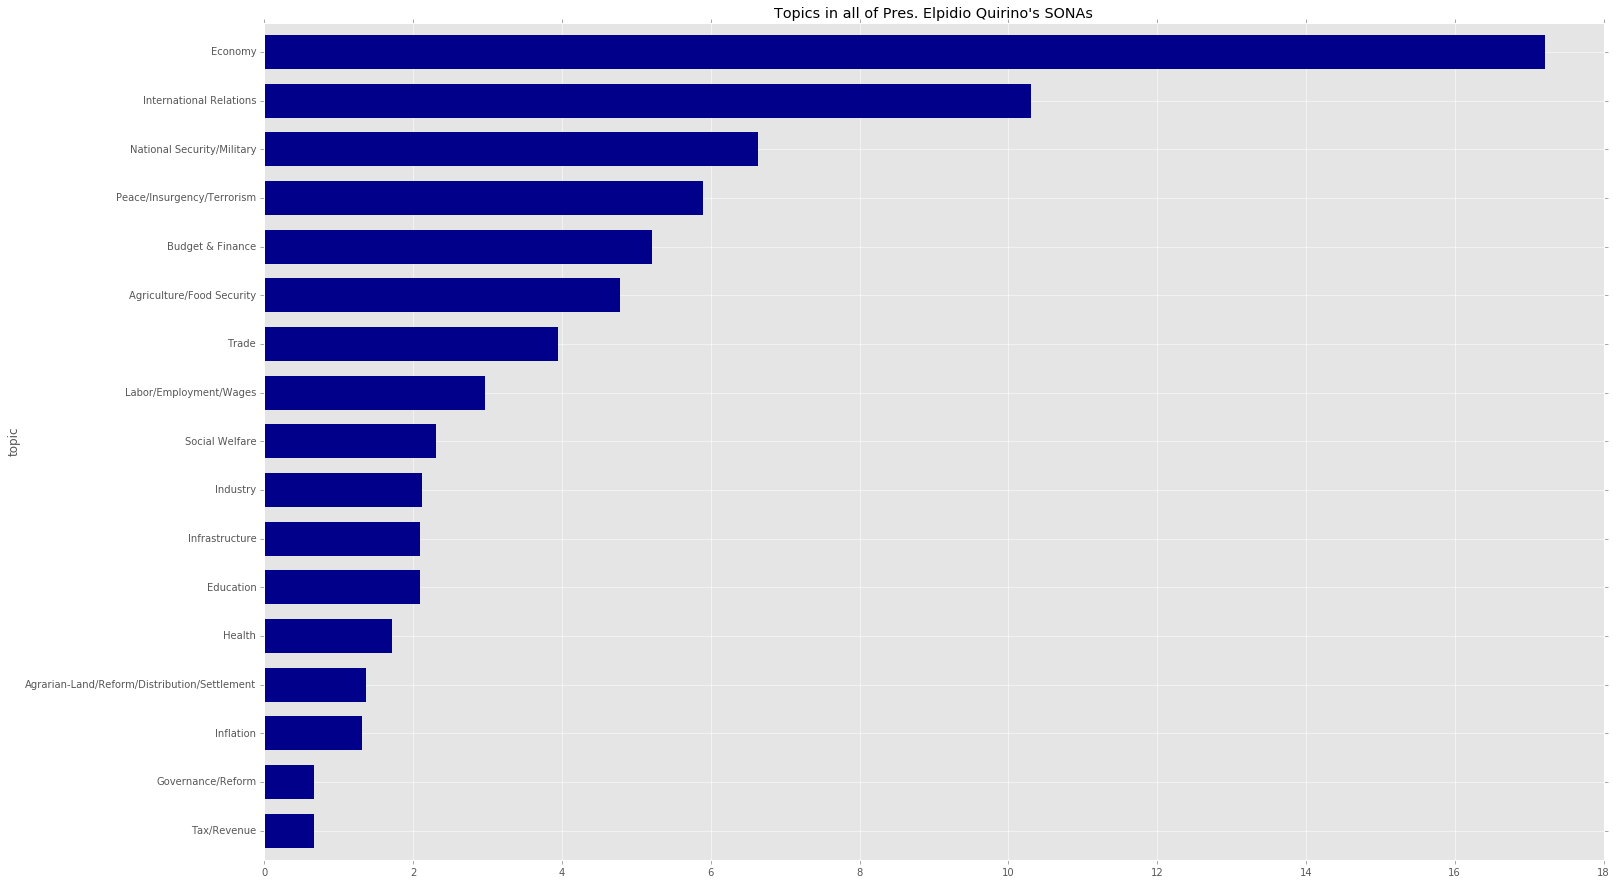

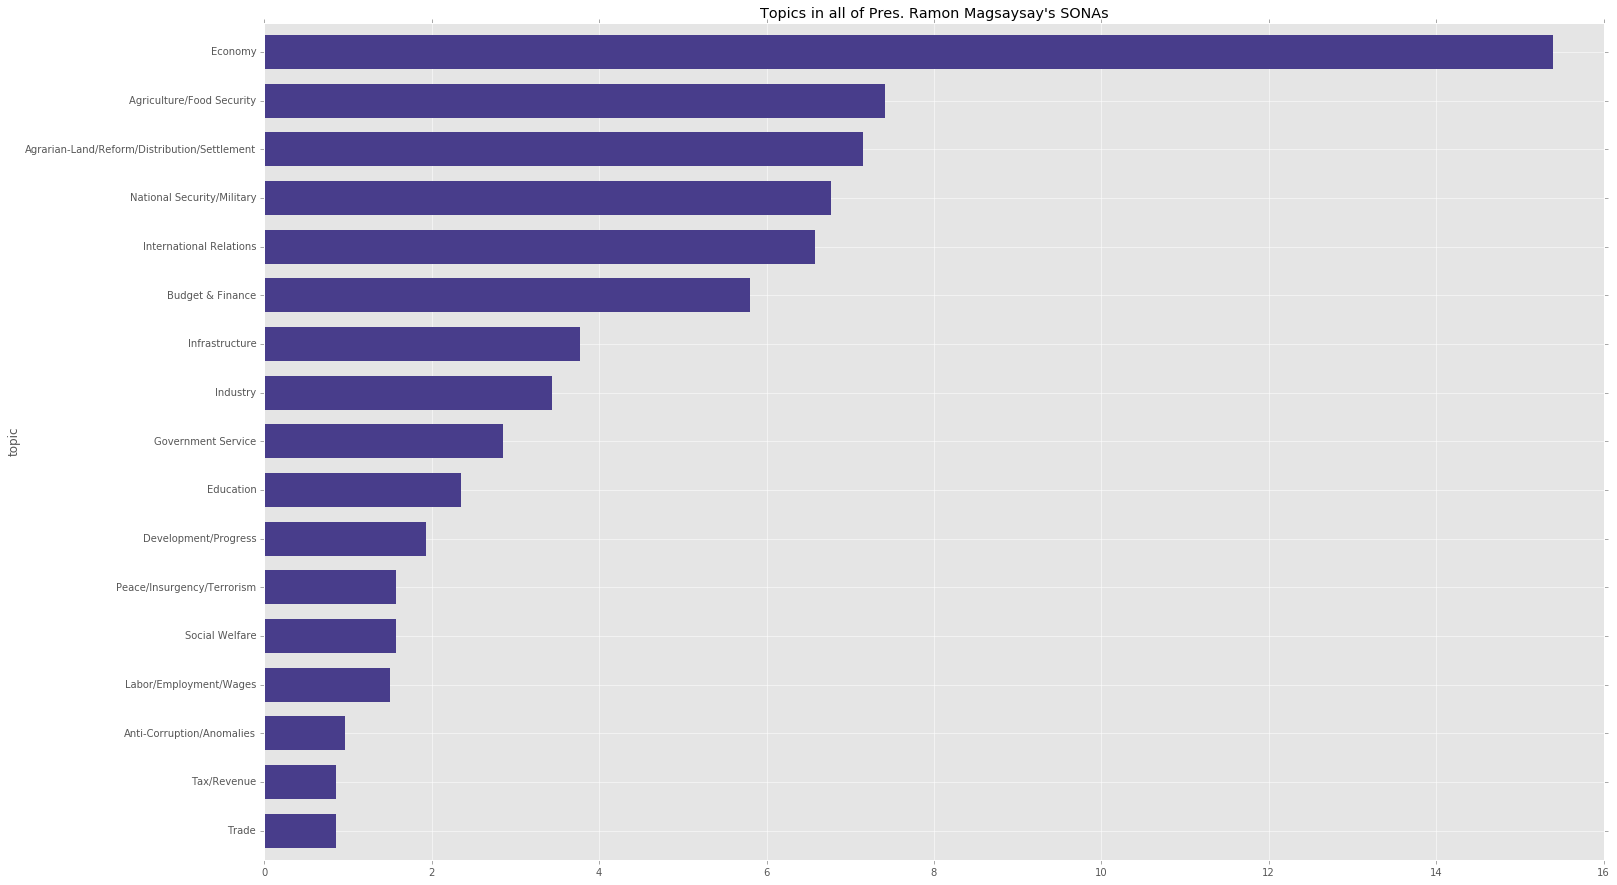

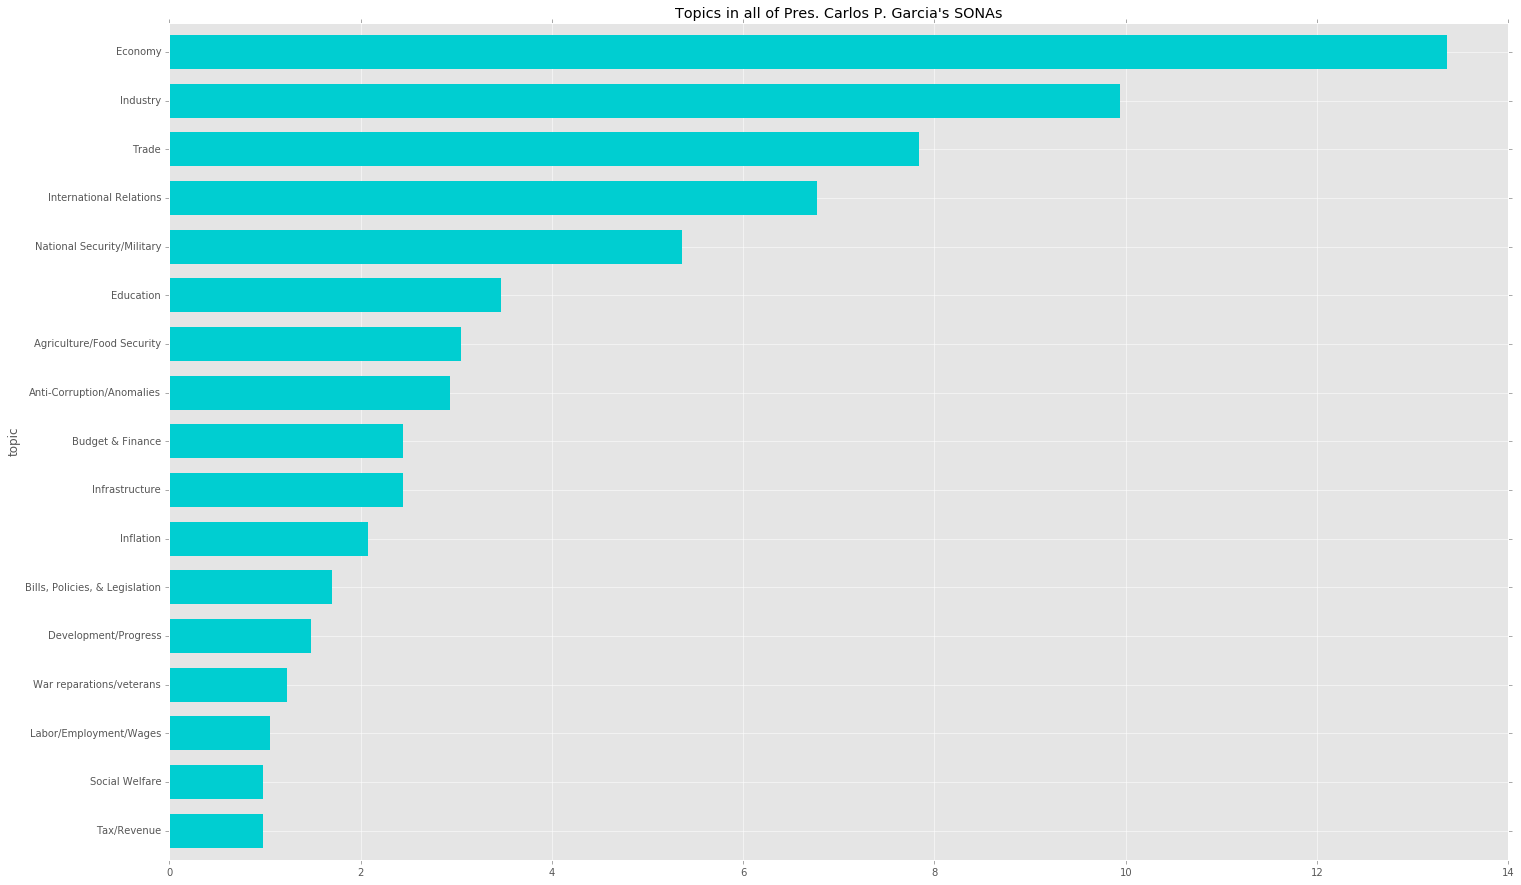

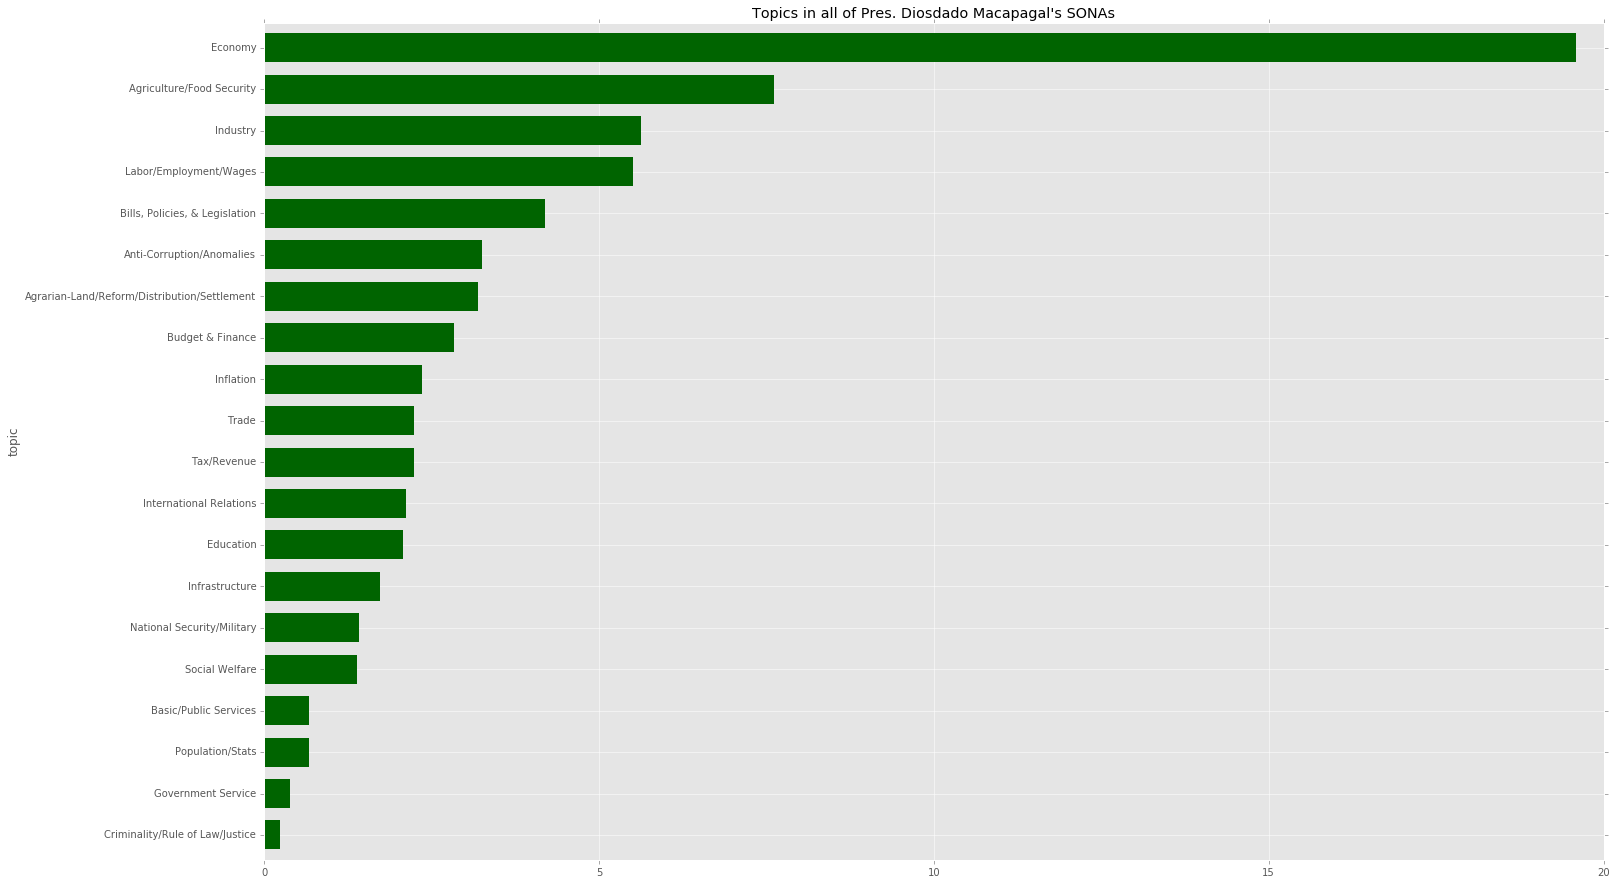

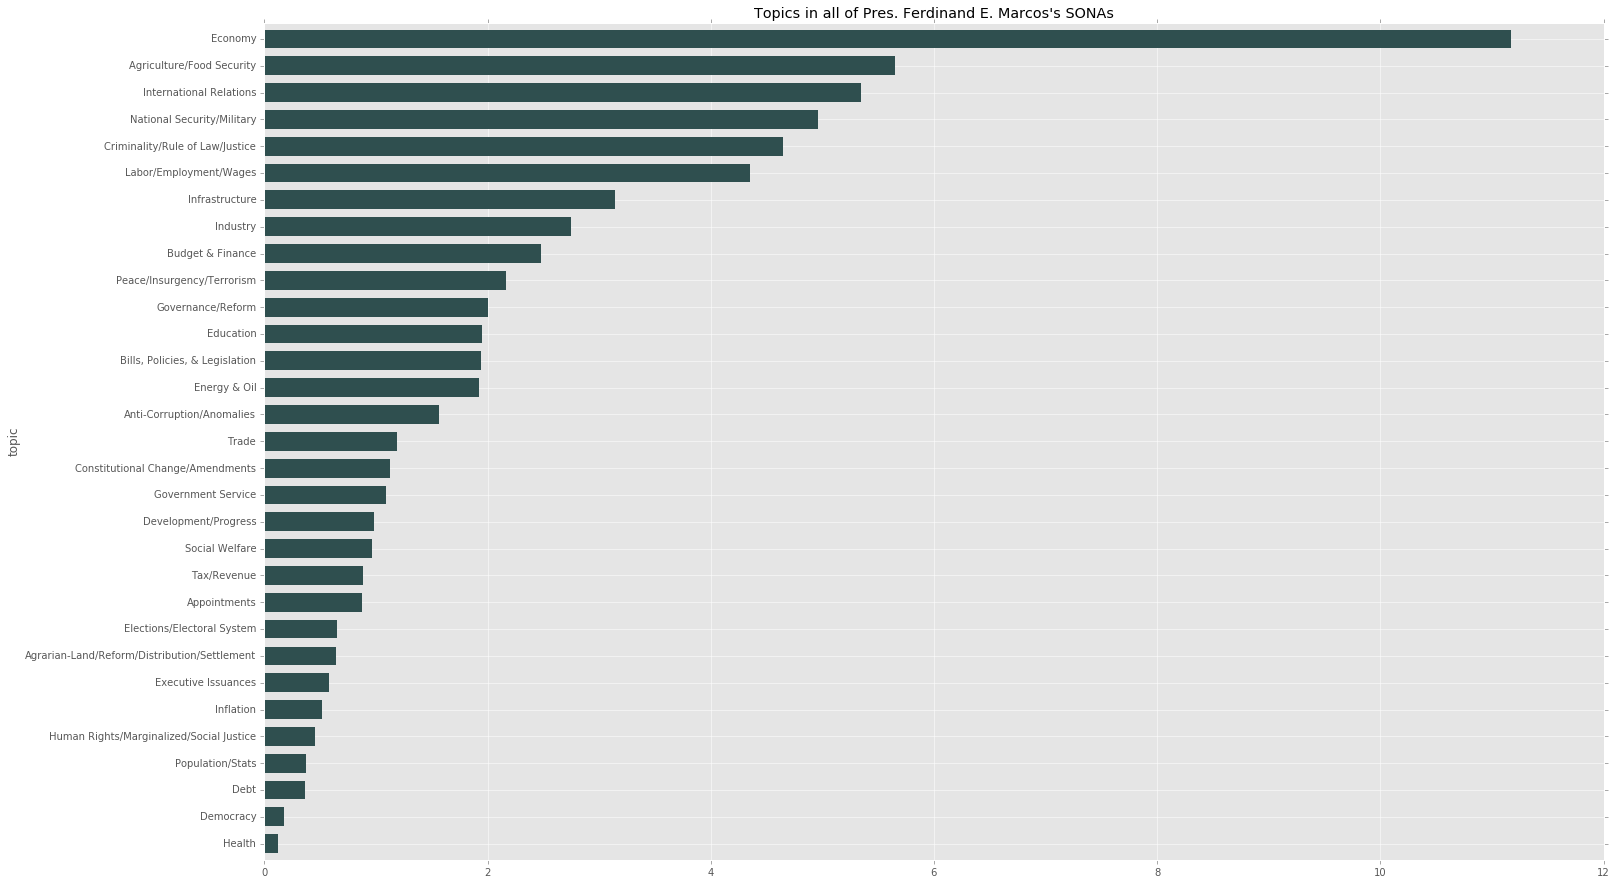

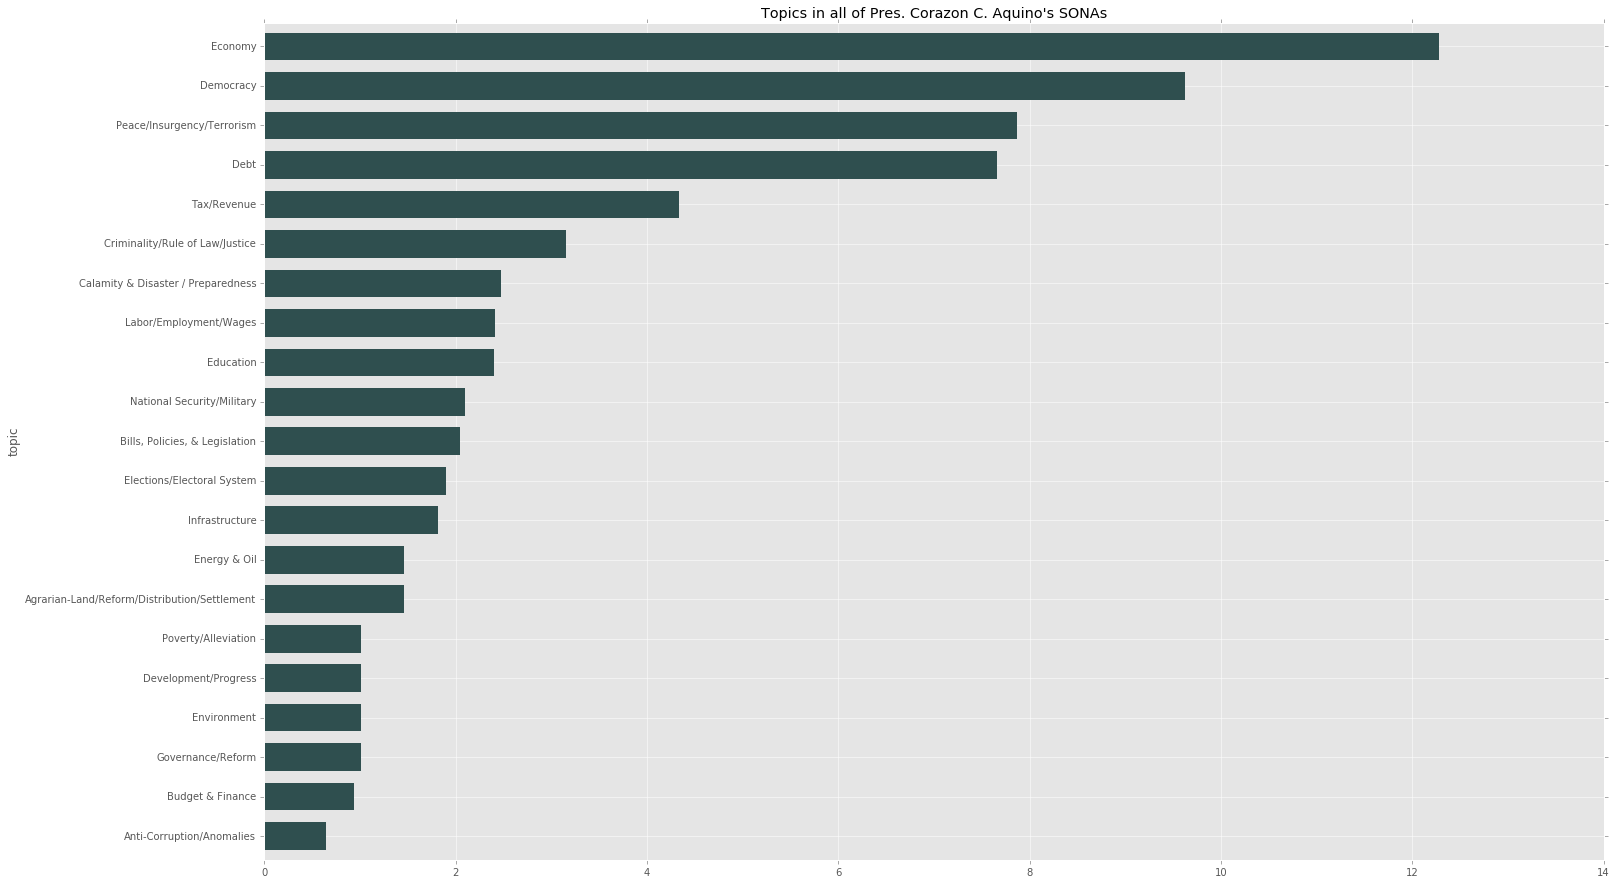

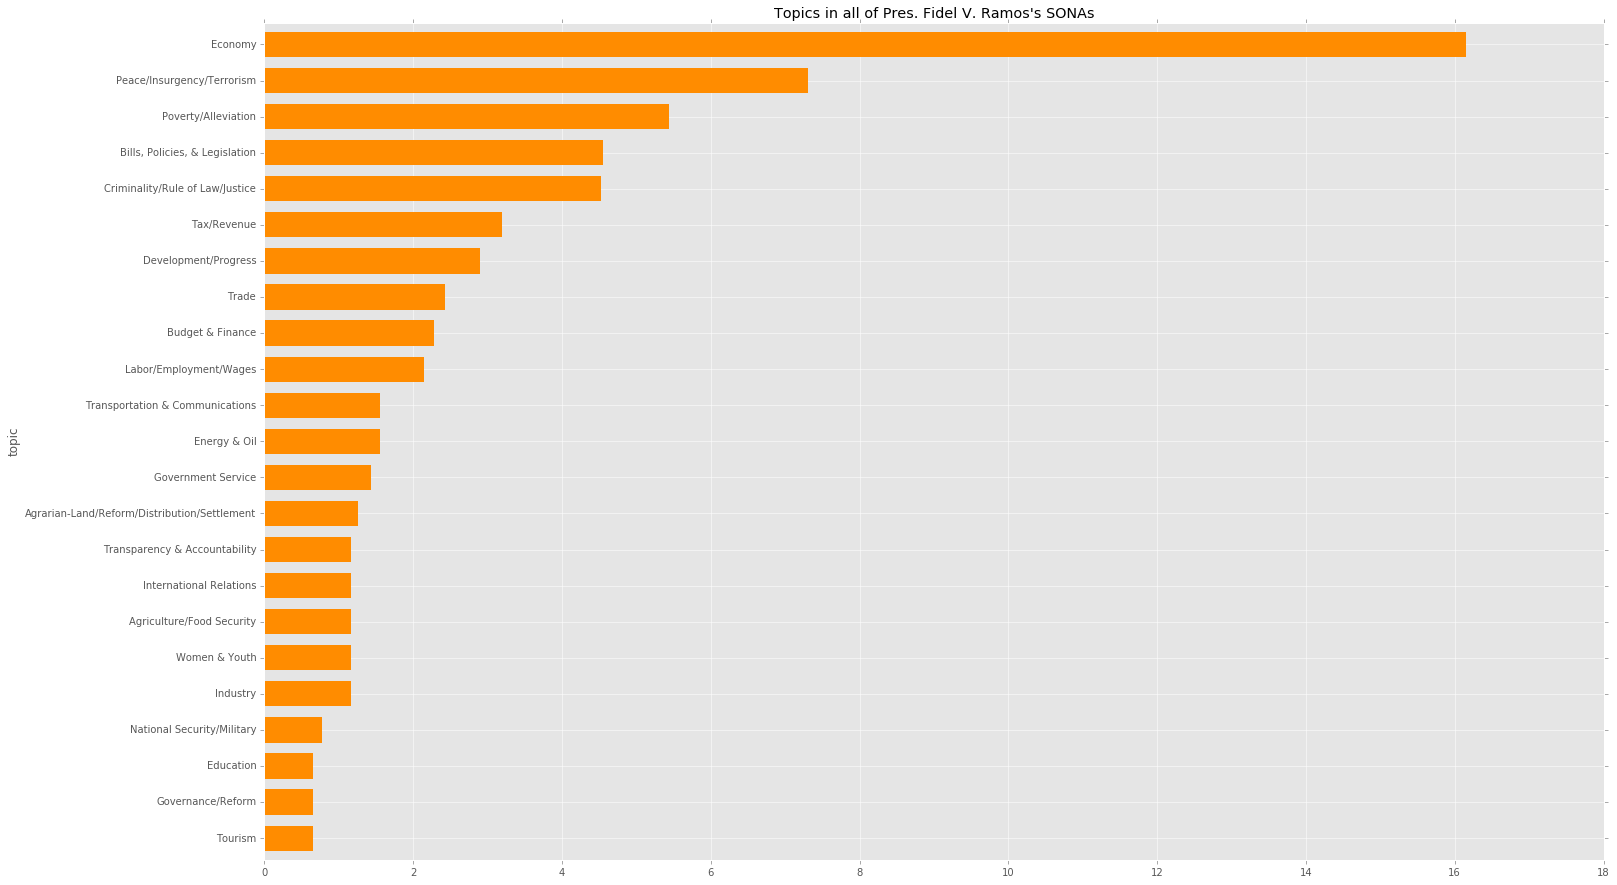

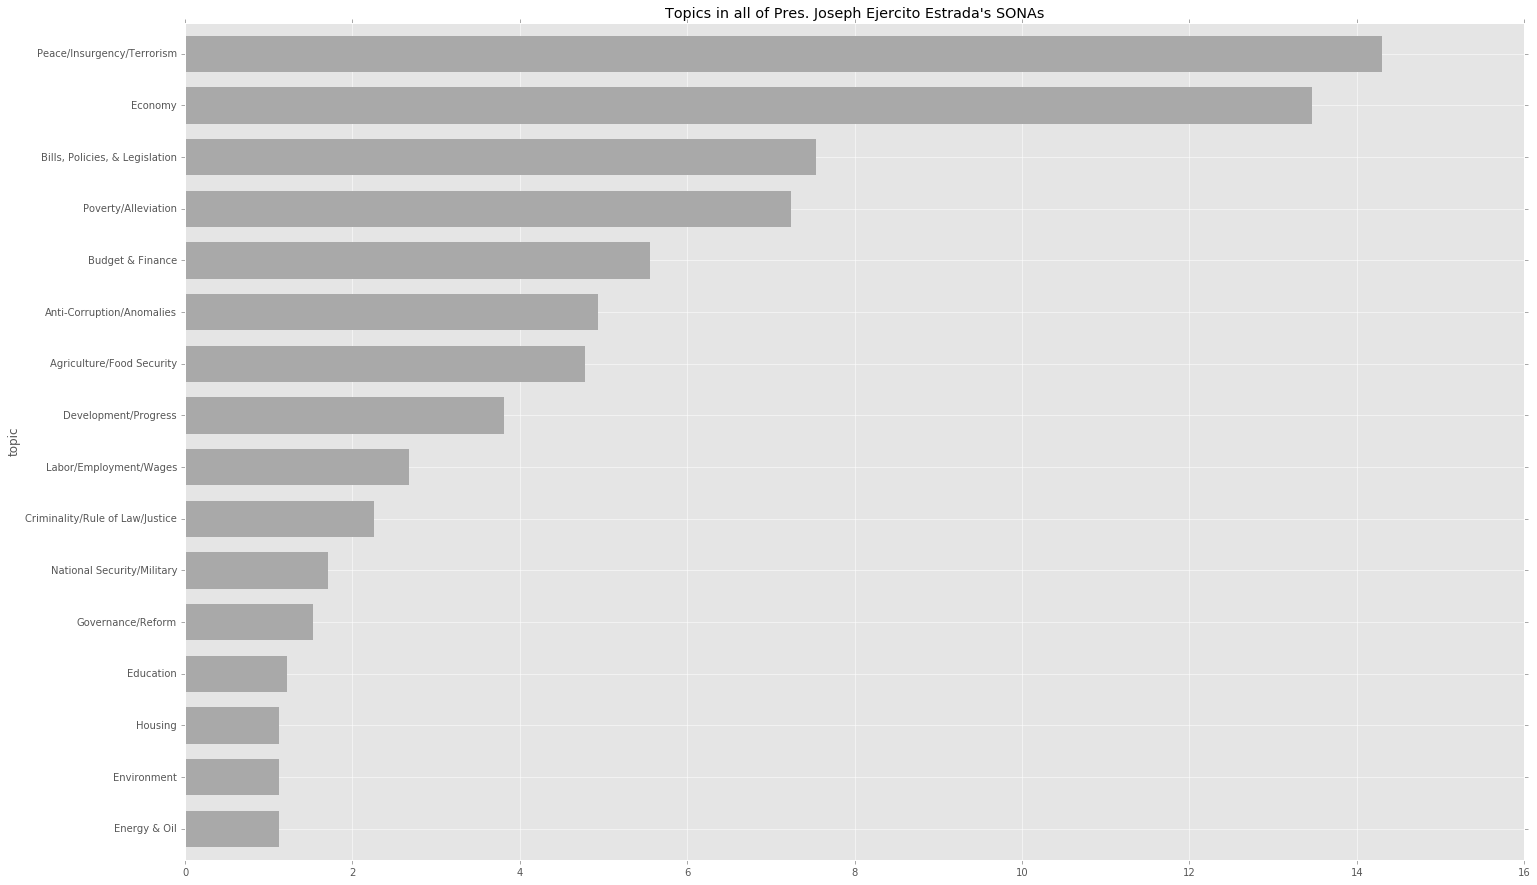

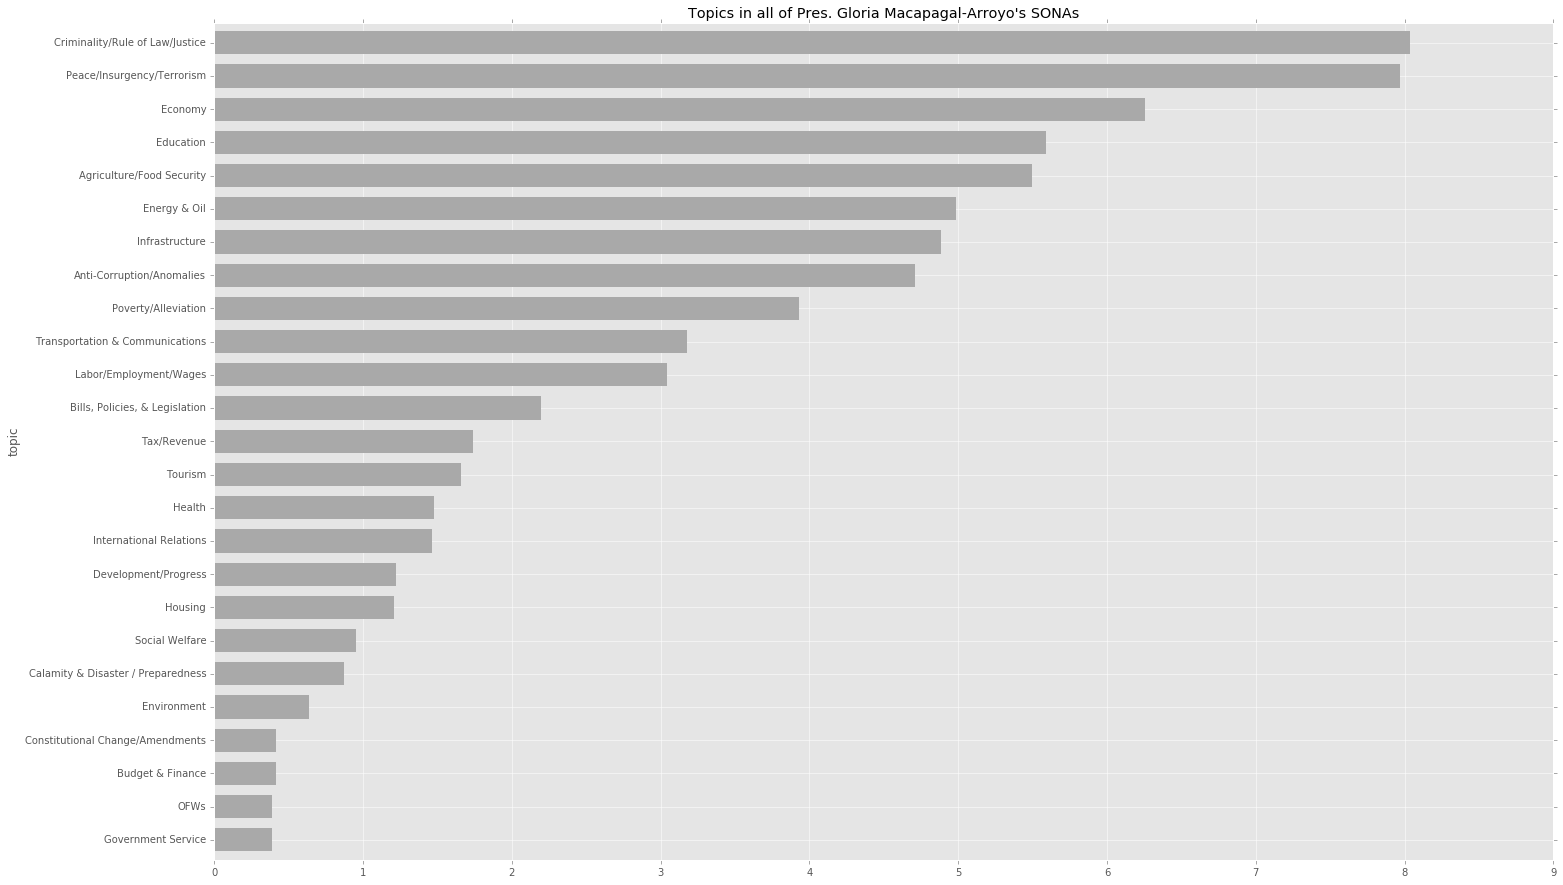

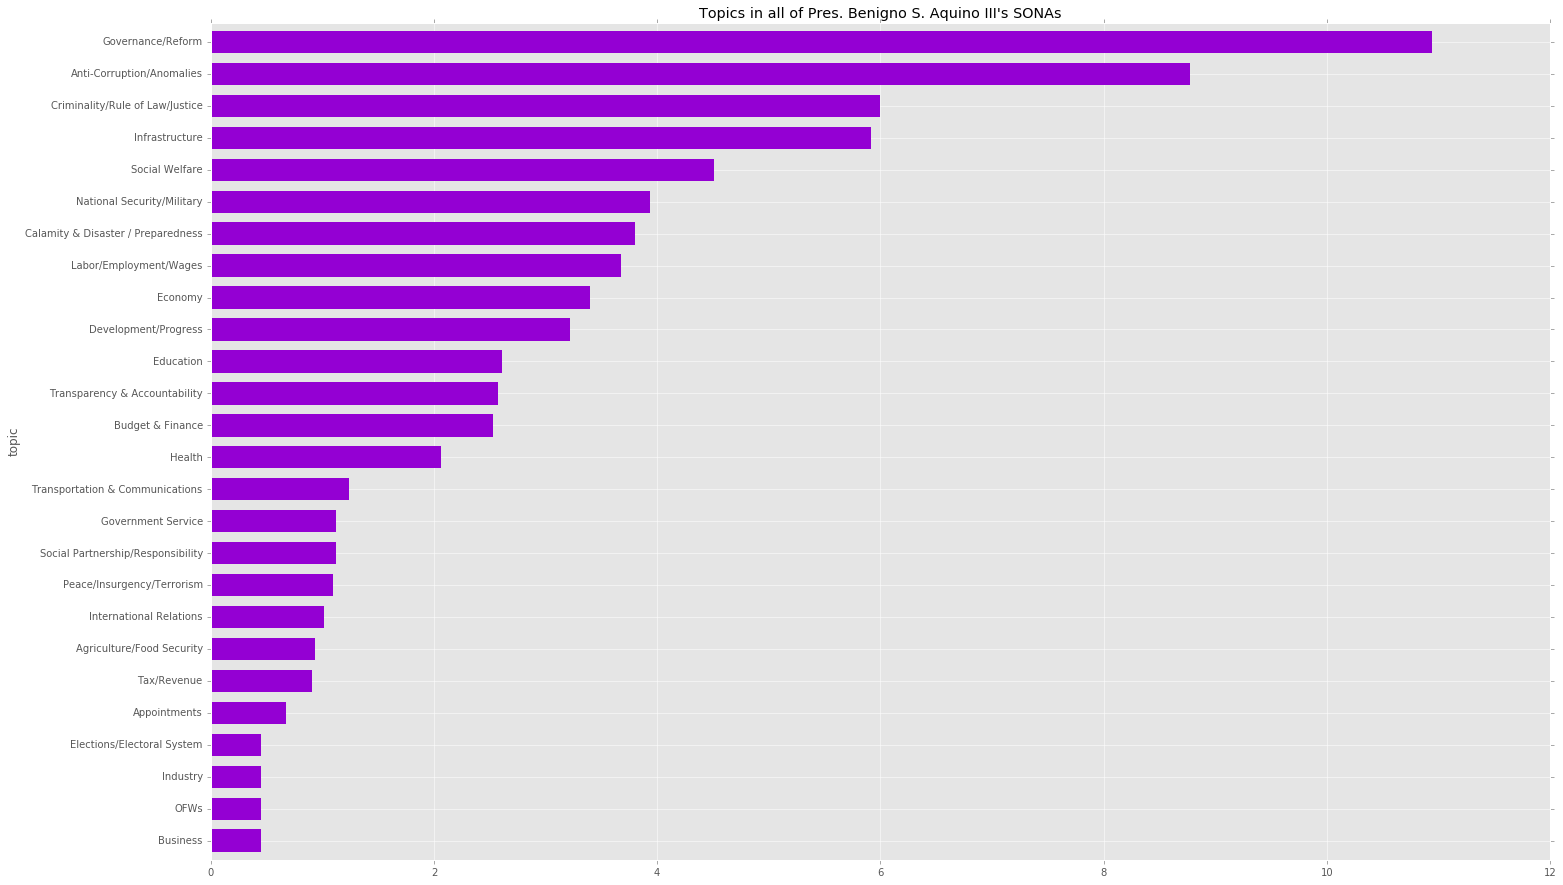

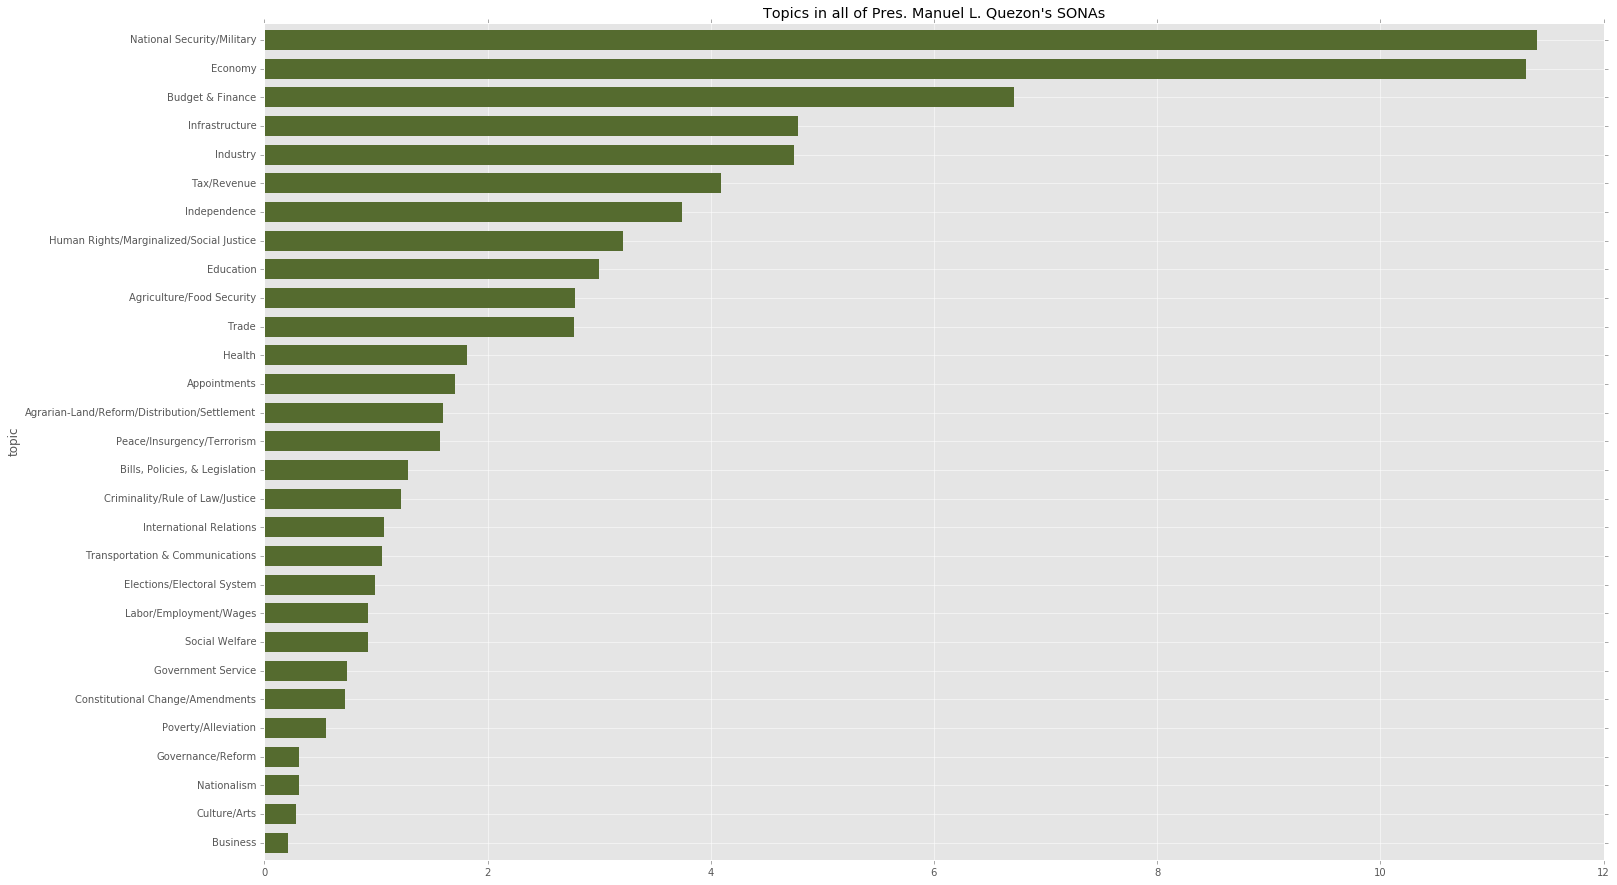

In [78]:
% matplotlib inline
from matplotlib.colors import cnames            # to ease the monotony

plt.style.use('ggplot')
np.random.seed(123456)                          # to get the same set of colors
colors = np.random.choice([c for c in cnames.keys() if c.startswith('dark')],
                          size=len(names), replace=False)

for color, pres in zip(colors, names):
    cond1 = df_by_author_topic.author == pres
    cond2 = df_by_author_topic.topic != 'Others'        # Do not include 'Others' category
    
    data = df_by_author_topic.loc[
        cond1 & cond2, ['topic', 'topic_main_pct']
    ].sort_values(by='topic_main_pct')
    data.set_index('topic', inplace=True)
    
    fig, ax = plt.subplots(figsize=(24, 15))
    
    data.plot(kind='barh', ax=ax, linewidth=0,
              color=color, width=0.7, legend=False)
    
    ttl = u"Topics in all of Pres. %s's SONAs" 
    ax.set_title(ttl % pres)
    ax.set_xlabel = 'Percentage'
    
    plt.savefig('Output\\Charts\\%s.png' % pres.encode('ascii', 'ignore'))
    data.to_csv('Output\\Tables\\%s.csv' % pres.encode('ascii', 'ignore'))

## Additional Stuff (Heatmap)
Although this wasn't part of the original plan, I think it's worth investigating what happens if we plot the `df_topics` dataframe (or some derivative thereof) as a heatmap of sorts. For that, we should probably create a new dataframe out of `df_topics` with the `topic` as the index and `delivered` as the columns. Here's how I approach this.

In [79]:
df_heatmap = pd.DataFrame()
for dt in sorted(pd.unique(df_topics.delivered.ravel())):
    cond = (df_topics.delivered == dt) & (df_topics.topic != 'Others')
    
    data = df_topics.loc[cond, ['topic', 'percent']].rename(
        columns={'percent': dt[:4]}
    )
    data.set_index('topic', inplace=True)
    
    df_heatmap = pd.concat([df_heatmap, data], axis=1)

In [80]:
df_heatmap.shape

(48, 77)

In [81]:
df_heatmap.fillna(0, inplace=True)

In [82]:
df_heatmap['1935']

Agrarian-Land/Reform/Distribution/Settlement     0.000000
Agriculture/Food Security                        0.000000
Anti-Corruption/Anomalies                        0.000000
Appointments                                     2.888889
Basic/Public Services                            0.000000
Bills, Policies, & Legislation                   0.000000
Budget & Finance                                 2.888889
Business                                         0.000000
Calamity & Disaster / Preparedness               0.000000
Constitutional Change/Amendments                 0.000000
Criminality/Rule of Law/Justice                  0.000000
Culture/Arts                                     0.000000
Debt                                             0.000000
Democracy                                        0.000000
Development/Progress                             0.000000
Economy                                          2.888889
Education                                        2.888889
Elections/Elec

In [83]:
df_heatmap.columns

Index([u'1935', u'1936', u'1937', u'1938', u'1939', u'1940', u'1941', u'1945',
       u'1946', u'1947', u'1948', u'1949', u'1950', u'1951', u'1952', u'1953',
       u'1954', u'1955', u'1956', u'1957', u'1958', u'1959', u'1960', u'1961',
       u'1962', u'1963', u'1964', u'1965', u'1966', u'1967', u'1968', u'1969',
       u'1970', u'1971', u'1972', u'1973', u'1974', u'1975', u'1976', u'1977',
       u'1978', u'1979', u'1980', u'1981', u'1982', u'1983', u'1984', u'1985',
       u'1987', u'1988', u'1989', u'1990', u'1991', u'1992', u'1993', u'1994',
       u'1995', u'1996', u'1997', u'1998', u'1999', u'2000', u'2001', u'2002',
       u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010',
       u'2011', u'2012', u'2013', u'2014', u'2015'],
      dtype='object')

In [84]:
df_heatmap.to_csv('Output\\Tables\\heatmap_values.csv')           # saved for future generations

Above, we prepare the dataframe to be used for our heatmap and, from the shape and column names of that DF, we can see that it's probably ready for action.

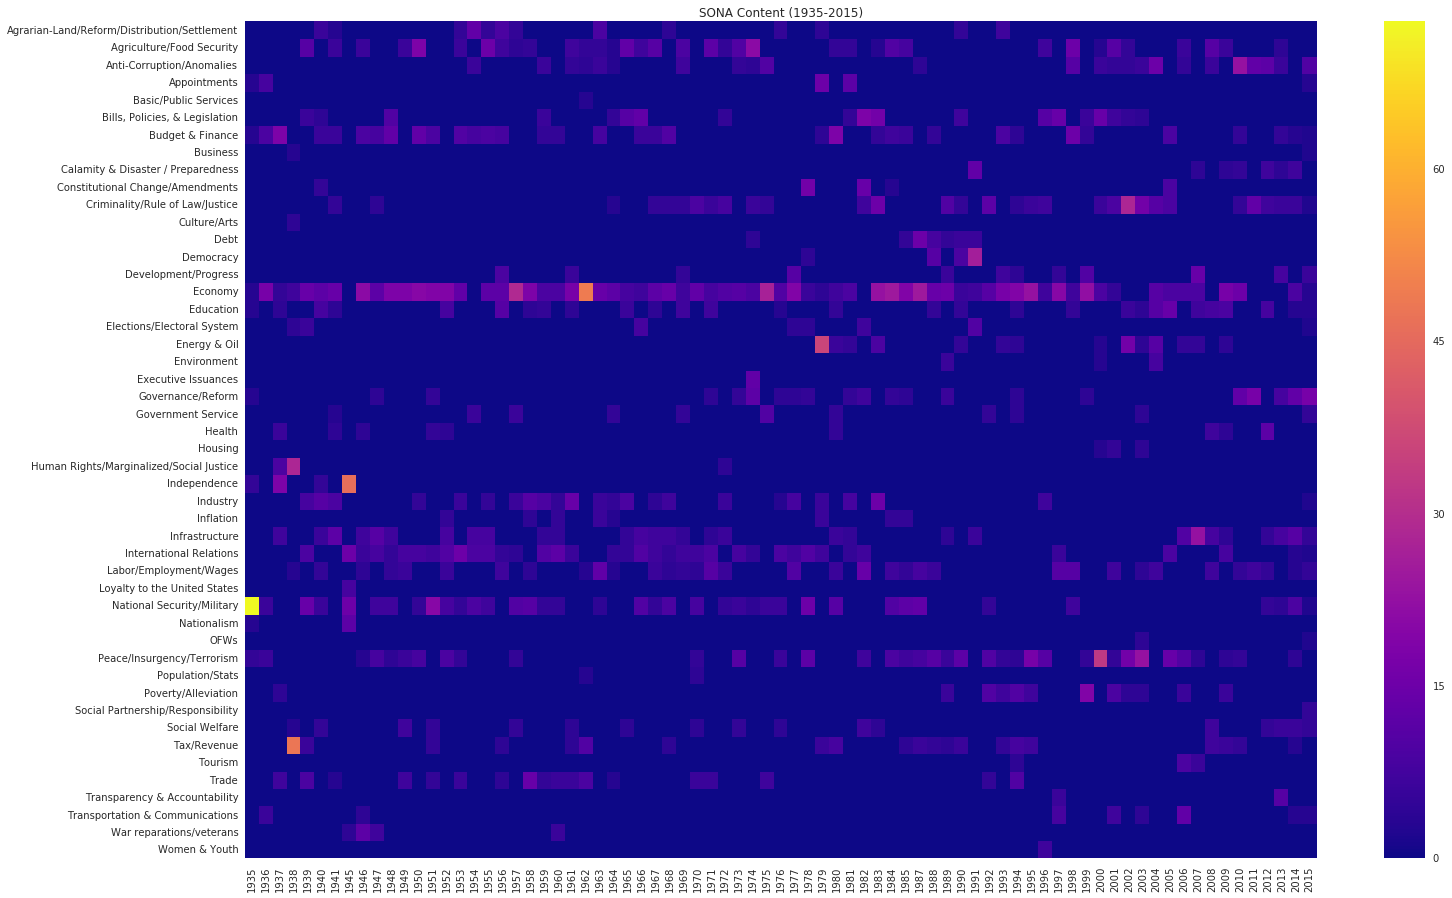

In [85]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(24, 15))
sns.heatmap(df_heatmap, ax=ax, cmap='plasma')
ax.set_title('SONA Content (1935-2015)')

plt.savefig('Output\\Charts\\heatmap.png')

## Credits
This post has been largely based on several text analysis articles and blog posts of the U.S. State of the Union Address and Philippine SONAs, including:
* ["Parsing the History of America"](http://priceonomics.com/parsing-the-history-of-america/) by (Priceonomics)
* ["The Language of the State of the Union"](http://www.theatlantic.com/politics/archive/2015/01/the-language-of-the-state-of-the-union/384575/) (The Atlantic)
* ["Data Science on State of the Union Addresses: Obama (2016) vs. Obama (2015) vs. ... vs. George Washington (1790)"](https://civisanalytics.com/blog/data-science/2016/01/15/data-science-on-state-of-the-union-addresses/) (Civis Analytics)
* ["On Presidents and Priorities: Distilling the Numbers out of the State of the Nation Address"](http://www.tjpalanca.com/2014/02/sona-words.html) (Troy Palanca)

## Update
The blog post accompanying this notebook is already available here.